# Practico Clustering - Text Mining 2021

Garagiola, Nazareno

Clustering is the process of grouping a set of documents into clusters of similar documents
Clustering Hypothesis: Documents in the same cluster behave similarly with respect to relevance to information


## Requerimientos

In [1]:
import spacy
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold
from collections import Counter
%matplotlib inline

In [6]:
!python3 -m spacy download es_core_news_md > trash.txt
#!python3 -m spacy download es_core_news_sm

## Carga del Corpus

In [2]:
f = open("lavoztextodump.txt", 'r')
text = f.read()[:500000]
text = text.replace('"', '')
text = text.replace('-\n', '\n')

In [3]:
# antes de correr esto, hay que correr la instalacion y resetear el runtime
nlp = spacy.load("es_core_news_md", vectores=False, entity=False)

lemmas = []
words = []
doc = nlp(text)
for token in doc:
    if len(token) > 1 and token.is_alpha: #alfabeticos e ignoro puntuaciones
        lemmas.append(token.lemma_.lower())
        words.append(token.text)


Si están trabajando en Colab, es normal que al hacer el load de Spacy aparezca un error.

**`ModuleNotFoundError: No module named 'es_core_news_md'`**.

Reinicien el Kernel/Runtime (usen el menú de arriba o el botón en la notebook), salteen la celda de instalación (la de abajo) y ejecuten la celda previa de vuelta. 

    `!python3 -m spacy download es_core_news_md > trash.txt`


## Preprocesamiento

-> Preproceso: Lemmatizacion, catergoria morfosintactica (POS), etc

-> Hacer diferentes aproximacione spara categorizar palabras, por contexto en diferentes tamaños de ventanas

In [5]:
counter_lemma = Counter(lemmas)
counter_words = Counter(words) #tambien se podria usar este

In [6]:
#minima cantidad de veces que deseo que una palabra este en el documento.
MIN_FREQ = 30

def word_filter(token):
    """
    Pequeña funcion que usaremos para filtrar las palabras
    """
    return (not token.is_alpha or token.is_digit or not counter_lemma[token.lemma_] >= MIN_FREQ)

with open("stopwords.txt",'r') as f:
    stopwords = f.read().split('\n')

def not_a_stopword(token):
    """
    Funcion que toma un token de Spacy y revisa que su lemma sea o on una 
    stopword en español
    """
    return (token.is_alpha and (not token.lemma_.lower() in stopwords))


def immediate_related_words(span):
    """
    Funcion que a partir de un Span (parte continua del doc) retorna una lista
    con los lemmas de las palabras que no sean stopwords
    """
    tokens = list(filter(not_a_stopword, doc[close_lft:close_rgt]))
    return list(map(lambda token: token.lemma_, tokens))

def keywords_in(span):
    """
    Funcion que a partir de un Span, retorna una lista con los lemmas de las 
    palabras del span que no sean stopwords ni tampoco no sean relevantes.
    (la funcion )
    """
    tokens = list(filter(
        lambda token: not word_filter(token) and not_a_stopword(token), span))
    return list(map(lambda token: token.lemma_, tokens))


In [7]:
triplas = {}
tag = {}
pos = {}
close_context = {}
large_context = {}

for token in doc:
    if word_filter(token): continue
    triplas[token.lemma_] = {}
    tag[token.lemma_] = {}
    pos[token.lemma_] = {}
    close_context[token.lemma_] = {}
    large_context[token.lemma_] = {}


In [8]:
close_window, large_window = 3, 20
for token in doc:
    if word_filter(token): continue

    i = token.i
    word = token.lemma_.lower()
    # Cargo part of speech de cada palabra lematizada
    if not token.pos_ in pos[word].keys():
        pos[word][token.pos_] = 0
    pos[word][token.pos_] += 1

    # Cargo tag de cada palabra lematizada
    if not token.tag_ in tag[word].keys():
        tag[word][token.tag_] = 0
    tag[word][token.tag_] += 1

    #Triplas de dependencias. Notar que busco el root de la frase en la que la 
    #palabra siguiente este, y esta puede no necesariamente estar en mis palabras
    #claves que superan el filtro.
    if not i == len(doc) - 1:
        tripla = (f"obj: {word} - dep : {token.dep_} - root: {doc[i+1].head.lemma_}") # - context: {span}")
        if not tripla in triplas[word].keys():
            triplas[word][tripla] = 0
        triplas[word][tripla] += 1

    #contexto inmediato, con una ventana 1 de distancia, sin stopwords
    close_lft, close_rgt = i-close_window, i+close_window
    if not (close_lft <= 0 and close_rgt >= len(doc)):
        imm_related_words = immediate_related_words(doc[close_lft:close_rgt])
        for w in imm_related_words:
            if w == word: continue
            if not w in close_context[word].keys():
                close_context[word][w] = 0
            close_context[word][w] += 1

    #contexto mas grande, solo de las palabras que me interesan sin stopwords
    #y que van a estar en un cluster luego.

    large_lft, large_rgt = i-large_window, i+large_window
    if not (large_lft <= 0 and large_rgt >= len(doc)):
        keywords_in_context = keywords_in(doc[large_lft: large_rgt])
        for w in keywords_in_context:
            if w == word: continue
            if not w in large_context[word].keys():
                large_context[word][w] = 0
            large_context[word][w] += 1




---



In [181]:
"""
for sent in doc.sents:
    for token in sent:
        if word_filter(token): continue
        i = token.i
        word = token.lemma_.lower()
        keywords_in_context = keywords_in(sent)
        for w in keywords_in_context:
            if w == word: continue
            if not w in large_context[word].keys():
                large_context[word][w] = 0
            large_context[word][w] += 1
"""
pass



---



Cargamos todas las caracteristicas que recogimos en el pre-procesamiento y las guardamos en nuevo diccionario cuyas claves tambien son las palabras lematizadas que analizamos.

In [9]:
feats = {}
for token in doc:
    if word_filter(token): continue
    word = token.lemma_
    feats[word] = {**tag[word], **pos[word], **triplas[word], **large_context[word], **close_context[word]}

In [10]:
print(f"Sample word 'ahora': {feats['ahora']}")

Sample word 'ahora': {'ADV___': 60, 'ADV': 60, 'obj: ahora - dep : advmod - root: parejo': 1, 'obj: ahora - dep : fixed - root: trabajar': 1, 'obj: ahora - dep : advmod - root: Nada': 1, 'obj: ahora - dep : advmod - root: comprar': 1, 'obj: ahora - dep : advmod - root: entender': 1, 'obj: ahora - dep : advmod - root: centrar': 1, 'obj: ahora - dep : advmod - root: monopolizar': 1, 'obj: ahora - dep : advmod - root: reelegir': 1, 'obj: ahora - dep : advmod - root: &': 1, 'obj: ahora - dep : advmod - root: presidente': 2, 'obj: ahora - dep : advmod - root: despacio': 1, 'obj: ahora - dep : advmod - root: ola': 1, 'obj: ahora - dep : advmod - root: sentir': 1, 'obj: ahora - dep : advmod - root: sospechoso': 1, 'obj: ahora - dep : advmod - root: ser': 1, 'obj: ahora - dep : advmod - root: promediar': 2, 'obj: ahora - dep : advmod - root: CBD': 2, 'obj: ahora - dep : advmod - root: modelar': 1, 'obj: ahora - dep : advmod - root: hallazgo': 1, 'obj: ahora - dep : advmod - root: matrimoniar':

## Vectorización

Luego del pre-procesamiento, tenemos un diccionario de la forma {"palabra":"caracteristicas"}. A este le removemos las claves e ingresamos las caracteristicas a un arreglo, el cual [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) lo transformara en una matriz, con filas siendo las palabras y cada columna son las caracteristicas.

In [19]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
features, key_words, wid = [], {}, 0
for word in feats:
    key_words[word] = wid
    wid += 1
    features.append(feats[word])
matrix = vectorizer.fit_transform(X=features)


Ahora debemos normalizar la matriz (es decir, que los vectores tengan valores entre 0 y 1).
Uso [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), otra herramienta de sklearn para poder reducir la dimensionalidad de la matrix y descartar caracteristicas.

In [20]:
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1e-9)

normed_matrix = normalize(matrix, axis=1, norm='l1')

reduced_matrix = selector.fit_transform(normed_matrix)

print(matrix.shape, normed_matrix.shape, reduced_matrix.shape)

(273, 34968) (273, 34968) (273, 18380)


## Clustering

Una vez que ya tenemos nuestra matriz de caracteristicas como vectores normalizada, la usamos para alimentar la funcion que nos arma los clusters. Uso la implementacion de [nltk](https://tedboy.github.io/nlps/generated/generated/nltk.cluster.KMeansClusterer.html) ya que permite usar la similutud del coseno de forma natural, sin hacer mas procesamiento previo.

In [23]:
from nltk.cluster import kmeans, cosine_distance

def clustering(k, matrix):
    """
    k -> Cantidad de clusterers
    """
    clusterer = kmeans.KMeansClusterer(num_means=k, distance=cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix, assign_clusters=True)
    return clusters

In [24]:
NUM_CLUSTERS = 40
cluster =  clustering(NUM_CLUSTERS, normed_matrix)

In [ ]:
for i in range(NUM_CLUSTERS):
    c = [token for token in key_words if cluster[key_words[token]]==i]
    print(f"Cluster {i}:\n {c}")

In [25]:
adjetivos = [word for word in key_words if cluster[key_words[word]]==cluster[key_words['gran']]]
numeros = [word for word in key_words if cluster[key_words[word]]==cluster[key_words['cuatro']]]
roles = [word for word in key_words if cluster[key_words[word]]==cluster[key_words['estudiante']]]
verbos = [word for word in key_words if cluster[key_words[word]]==cluster[key_words['lograr']]]
stop1 = [word for word in key_words if cluster[key_words[word]]==cluster[key_words['cuando']]]



---



# LSA - t-SNE

In [82]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd = TruncatedSVD(n_components=100, n_iter=5)
lsa_data = svd.fit_transform(X=reduced_matrix)


tsne = TSNE(n_components=2, random_state=0, n_iter=500) #ultimo param para que sea mas rapido
tsne_data = tsne.fit_transform(reduced_matrix)

tsne_data.shape, lsa_data.shape

((273, 2), (273, 100))

In [70]:
data = [(tsne_data[i], cluster[i], list(key_words.keys())[i]) for i in range(wid)]
df_clustered = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in data],
    columns=["dim1", "dim2", "cluster", "word"]
)

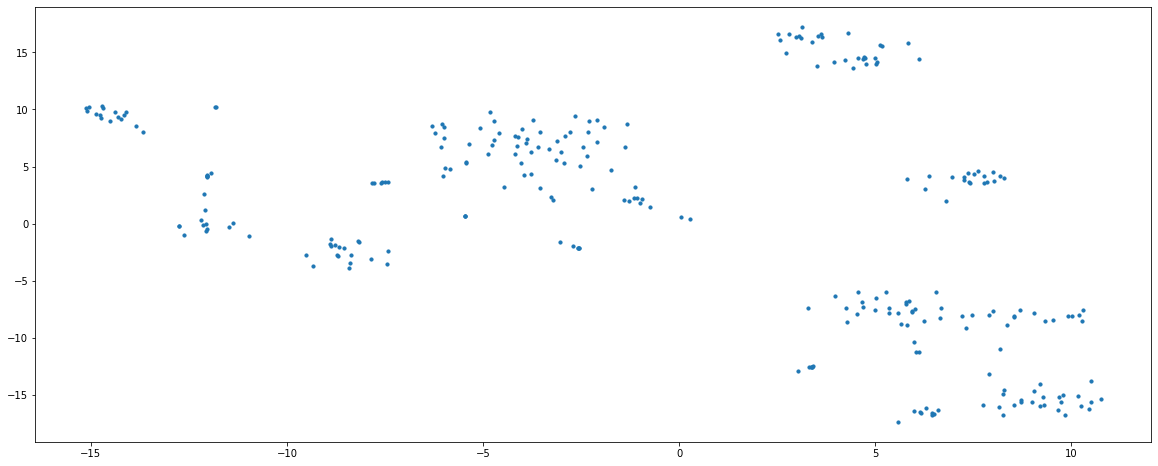

In [73]:
plt.figure(figsize=(20, 8))
plt.scatter(x=df_clustered['dim1'],y=df_clustered['dim2'], s=10, cmap='viridis')
#for i in range(wid):
#    plt.annotate(df_clustered['word'][i], (df_clustered['dim1'][i], df_clustered['dim2'][i]))

plt.show()

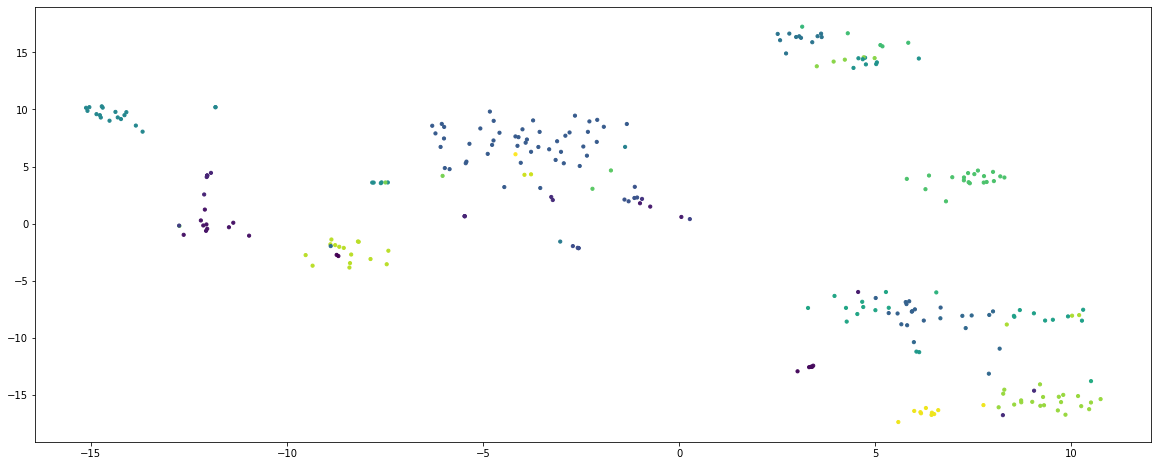

In [74]:
plt.figure(figsize=(20, 8))
plt.scatter(x=df_clustered['dim1'],y=df_clustered['dim2'], s=10, c=df_clustered['cluster'], cmap='viridis')
#for i in range(wid):
#    plt.annotate(df_clustered['word'][i], (df_clustered['dim1'][i], df_clustered['dim2'][i]))

plt.show()lsa_data.shape

In [126]:
def diff_between_clusters(c1, c2, key):
    diff = {'c1-c2': [], 'c2-c1': []}
    X = [word for word in key_words if c1[key_words[word]]==c1[key_words[key]]]
    Y = [word for word in key_words if c2[key_words[word]]==c2[key_words[key]]]

    for elem in X:
        if not elem in Y:
            diff['c1-c2'].append(elem)

    for elem in Y:
        if not elem in X:
            diff['c2-c1'].append(elem)
    
    return diff

In [109]:
lsa_cluster = clustering(k=NUM_CLUSTERS, matrix=lsa_data)

In [130]:
diff_between_clusters(cluster, lsa_cluster, "gobernar")

{'c1-c2': ['sentir', 'intentar'],
 'c2-c1': ['casar',
  'tiempo',
  'momento',
  'proyectar',
  'conflicto',
  'debatir',
  'grupo',
  'embargar',
  'acto',
  'jefe',
  'hombre',
  'interior',
  'presidente',
  'lugar',
  'derecho',
  'país',
  'fin',
  'ministro',
  'diario',
  'mes',
  'gobernador',
  'peronismo',
  'golpe']}